# Decomposition of isometric synthetic HDsEMG signals

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import emgkit

# Load NeuroKit and other useful packages
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import torch

logging.basicConfig(level=logging.INFO)  # 可显示具体参数信息
# logging.basicConfig(level=logging.WARNING)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    DEVICE = torch.device("cpu")
    logging.info("Using CPU version")

SEED = 42
FS = 2000


INFO:root:Using CUDA version


(6, 101601)


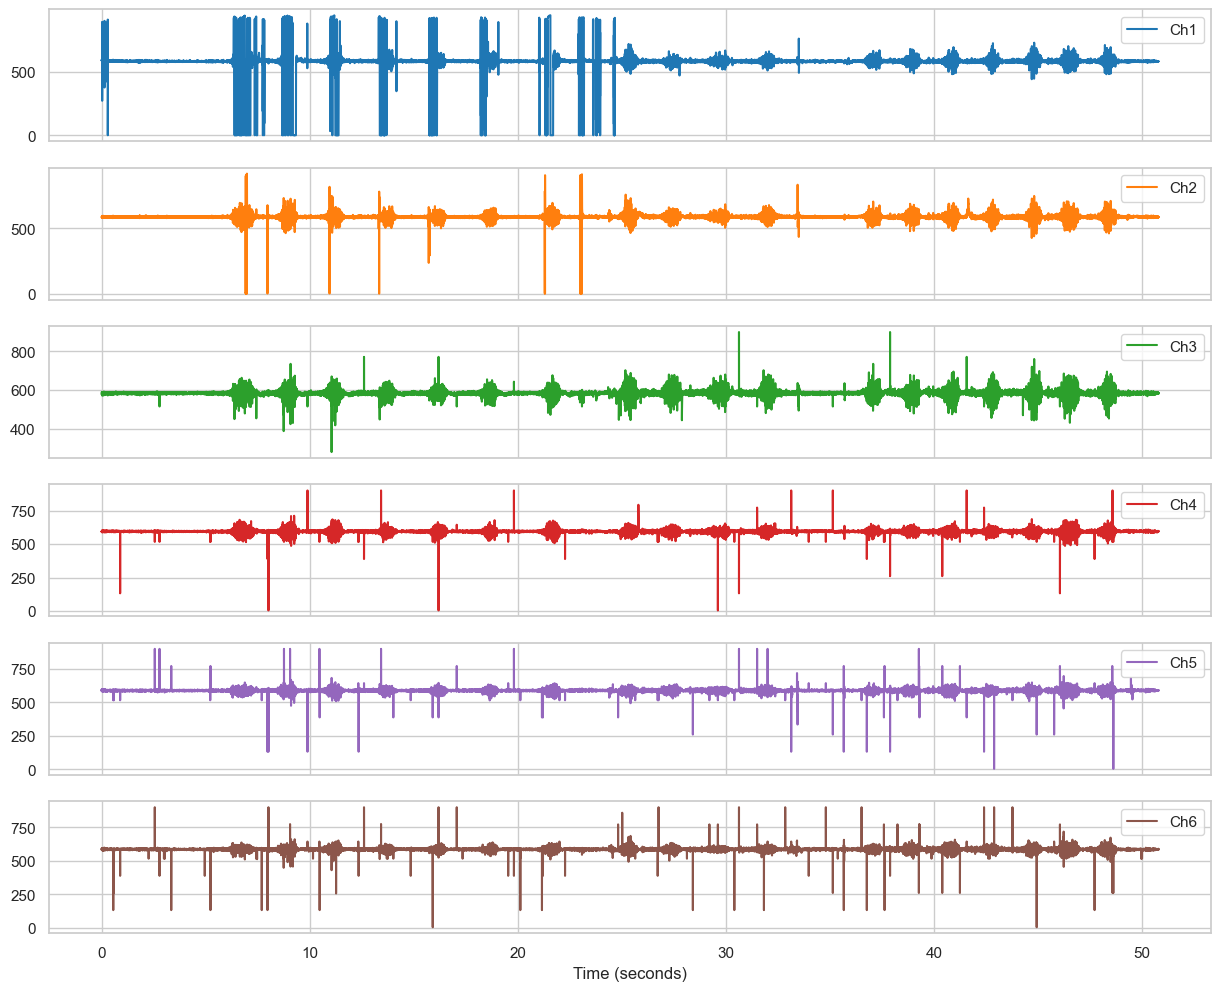

In [2]:
DATA_DIR = (
    # "C:\\Users\\Link\\OneDrive\\Work\\杂任务\\表面肌电\\三轮数据（10月）\\0926异常人"
    "C:\\Users\\Link\\OneDrive\\Work\\杂任务\\表面肌电\\三轮数据（10月）\\0923正常人"
)
SUBJECT_TYPE = "1"
SENSOR_TYPE = ""


def load_data(root: str, subject_type: str, sensor_type: str) -> np.ndarray:
    # 读取CSV文件
    data = pd.read_csv(
        os.path.join(root, f"六通道5mm-10mm-0.5mm-2_0923-{subject_type}.csv")
    )
    # data = pd.read_csv(os.path.join(root, f"0926右手第{subject_type}组.csv"))

    # 确保所有必要的通道都存在
    channel_names = ["CH1", "CH2", "CH3", "CH4", "CH5", "CH6"]
    for channel in channel_names:
        if channel not in data.columns:
            raise ValueError(f"Missing channel {channel} in the file.")

    # 提取通道数据并转换为NumPy数组
    channel_data = np.array([data[channel].values for channel in channel_names])

    return channel_data


channel_array = load_data(DATA_DIR, SUBJECT_TYPE, SENSOR_TYPE)
print(channel_array.shape)


# Visualize
emg_df = pd.DataFrame(
    {
        "Ch1": channel_array[0],
        "Ch2": channel_array[1],
        "Ch3": channel_array[2],
        "Ch4": channel_array[3],
        "Ch5": channel_array[4],
        "Ch6": channel_array[5],
    }
)

kwargs = {
    "title": f"Raw sEMG signal ({SUBJECT_TYPE})",
    "y_label": "Amplitude [\u03bcV]",
    "fig_size": (8, 14),
}


plt.rcParams["figure.figsize"] = (15, 12)  # 设置默认图形大小
nk.signal_plot(emg_df, sampling_rate=2000, subplots=True)

In [3]:
# 遍历每个通道并计算均值和方差
for i, channel_data in enumerate(channel_array):
    channel_mean = np.mean(channel_data)
    channel_variance = np.var(channel_data)
    print(f"通道 {i+1} 的均值: {channel_mean:.5f}, 方差: {channel_variance:.5f}")
# 进行中心化处理
channel_array = channel_array - np.mean(channel_array, axis=1, keepdims=True)

通道 1 的均值: 573.74799, 方差: 12382.56123
通道 2 的均值: 587.85208, 方差: 736.84958
通道 3 的均值: 584.37969, 方差: 276.87560
通道 4 的均值: 593.68274, 方差: 206.44133
通道 5 的均值: 589.01475, 方差: 199.77414
通道 6 的均值: 585.26427, 方差: 242.30441


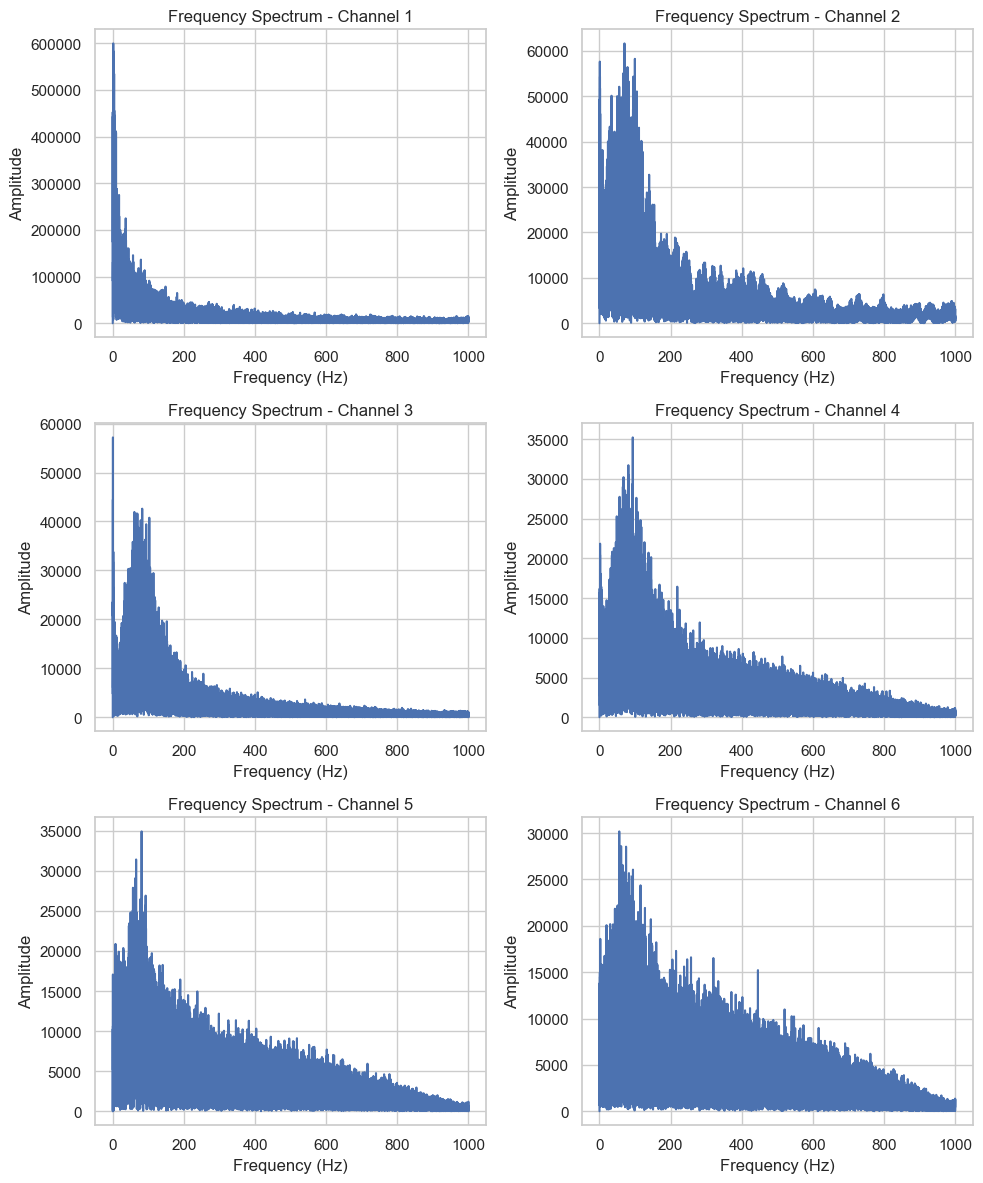

In [4]:
emgkit.preprocessing.plot_all_channels_frequency_spectrum(
    channel_array, fs=FS, figsize=(10, 4)
)

In [5]:
channel_array_removed_artifacts = np.zeros_like(channel_array)
import numpy as np
from scipy.signal import butter, filtfilt


def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a Butterworth bandpass filter to the EMG signal.

    Parameters:
    - data: The EMG signal data (1D numpy array).
    - lowcut: The low cutoff frequency (in Hz).
    - highcut: The high cutoff frequency (in Hz).
    - fs: The sampling rate of the signal (in Hz).
    - order: The order of the filter.

    Returns:
    - Filtered EMG signal (1D numpy array).
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    y = filtfilt(b, a, data)
    return y


# 遍历每个通道
for i in range(channel_array.shape[0]):
    # 计算当前通道的均值和标准差
    mean = np.mean(channel_array[i])
    std = np.std(channel_array[i])

    threshold = mean + 3 * std
    print(threshold)
    # 阈值检测 - 将超过阈值的值设为0
    # 注意：这里也可以将异常值替换为均值，或者使用其他合适的值
    channel_array_removed_artifacts[i] = np.where(
        np.abs(channel_array[i]) > threshold, mean, channel_array[i]
    )


filter_channel_array = bandpass_filter(
    channel_array_removed_artifacts, lowcut=20, highcut=500, fs=FS, order=5
)

333.8308719711878
81.43491999115616
49.918737804318226
43.10419882993811
42.40244454090131
46.69839067222537


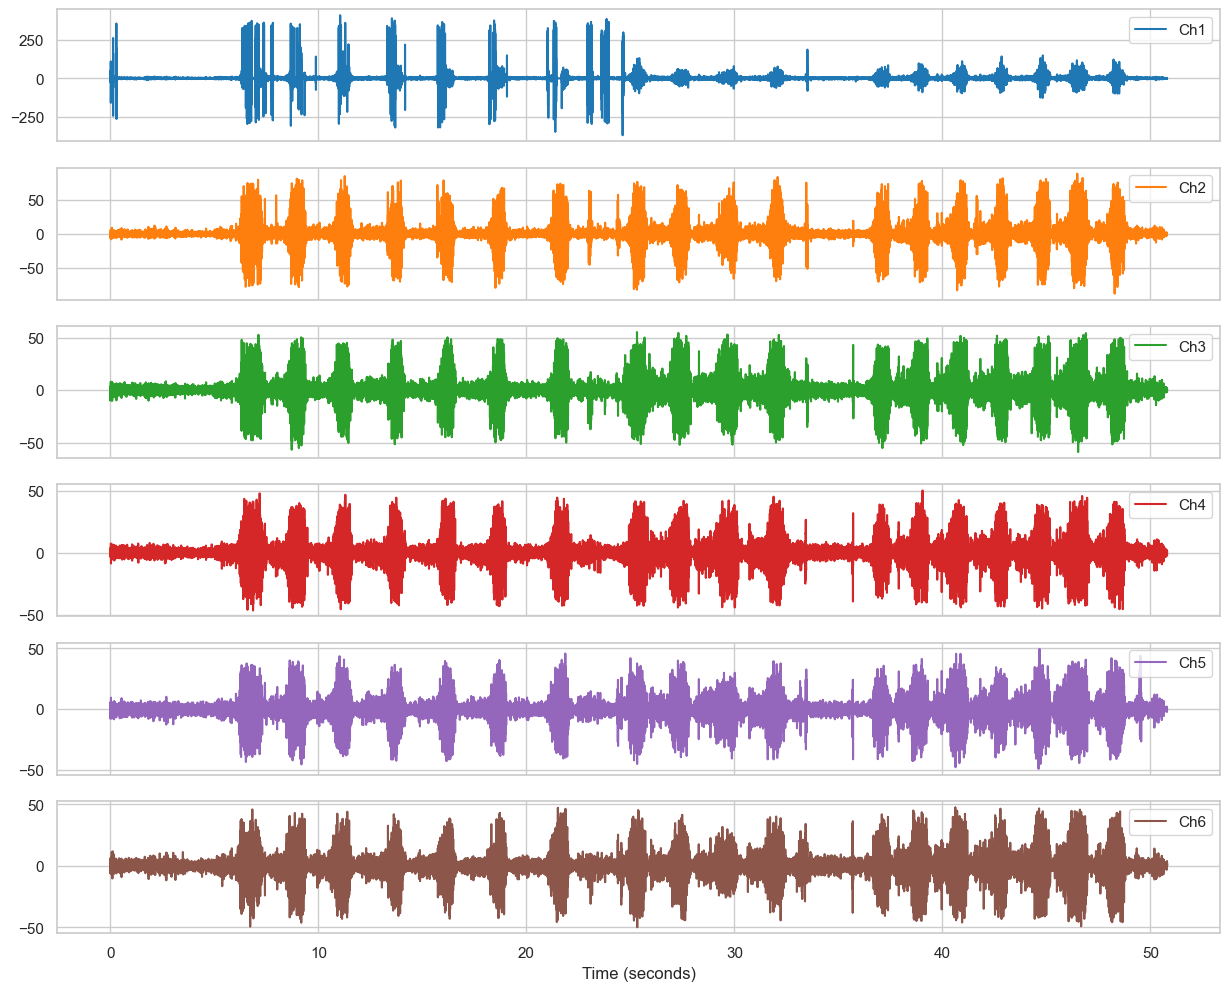

In [6]:
emg_df = pd.DataFrame(
    {
        "Ch1": filter_channel_array[0],
        "Ch2": filter_channel_array[1],
        "Ch3": filter_channel_array[2],
        "Ch4": filter_channel_array[3],
        "Ch5": filter_channel_array[4],
        "Ch6": filter_channel_array[5],
    }
)

kwargs = {
    "title": f"Preprocessed sEMG Signal({SUBJECT_TYPE})",
    "y_label": "Amplitude [\u03bcV]",
    "fig_size": (8, 14),
}
# plt.figure(figsize=(8, 19))
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 12)  # 设置默认图形大小
nk.signal_plot(emg_df, sampling_rate=2000, subplots=True)

## 根据肌肉活动强度特征，自动提取活动区间段信息
（以后再完善优化该功能）

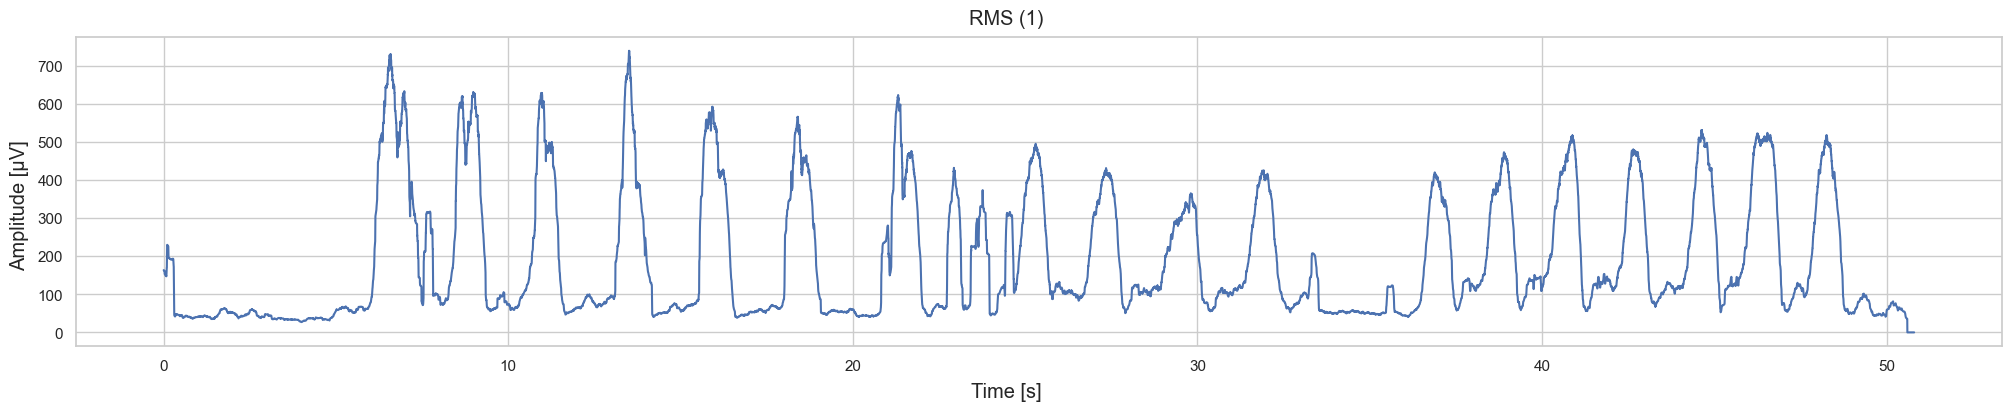

In [7]:
win_len = int(round(0.2 * FS))

emg_rms = np.zeros_like(filter_channel_array)
for i in range(filter_channel_array.shape[1] - win_len):
    cur_rms = (filter_channel_array[:, i : i + win_len] ** 2).sum(axis=1)
    emg_rms[:, i] = np.sqrt(cur_rms)
emg_rms = np.mean(emg_rms, axis=0)

import numpy as np


def is_stable(signal_segment, stable_threshold):
    """Check if the signal segment is stable."""
    return np.var(signal_segment) < stable_threshold


def adjust_point(rms_signal, point, direction, stable_duration, stable_threshold):
    """
    Adjust the point backward or forward to find a stable region.
    direction should be -1 for backward search (start point),
    and 1 for forward search (end point).
    """
    while point > 0 and point < len(rms_signal):
        segment_start = max(0, point - stable_duration) if direction == -1 else point
        segment_end = (
            point if direction == -1 else min(len(rms_signal), point + stable_duration)
        )
        if is_stable(rms_signal[segment_start:segment_end], stable_threshold):
            break
        point += direction
    return point


def detect_stimulations(rms_signal, threshold_factor=0, min_duration=2, FS=2000):
    mean_val = np.mean(rms_signal)
    std_val = np.std(rms_signal)

    threshold = mean_val + threshold_factor * std_val

    stable_threshold = (
        std_val * 0.5
    )  # Define a lower variance threshold to assess stability. 0.05
    stable_duration = (
        FS // 200  # 4
    )  # Number of samples that signal needs to be stable for half a second.

    stim_starts = []
    stim_ends = []

    is_stimulating = False
    stim_start_pos = None

    for i, value in enumerate(rms_signal):
        if value > threshold and not is_stimulating:
            # Potential start of stimulation
            is_stimulating = True
            stim_start_pos = i

        elif value < threshold and is_stimulating:
            # Potential end of stimulation
            if i - stim_start_pos >= (min_duration * FS):
                # Adjust the end point to ensure it's stable after the stimulation
                adjusted_end = adjust_point(
                    rms_signal, i, 1, stable_duration, stable_threshold
                )
                # Adjust the start point to ensure it's stable before the stimulation
                adjusted_start = adjust_point(
                    rms_signal, stim_start_pos, -1, stable_duration, stable_threshold
                )

                # Only add the points if they are different from the initial ones
                if adjusted_end != i or adjusted_start != stim_start_pos:
                    stim_starts.append(adjusted_start / FS)
                    stim_ends.append(adjusted_end / FS)
            is_stimulating = False

    # Check if a stimulation was ongoing at the end of the signal
    if is_stimulating and len(rms_signal) - stim_start_pos >= (min_duration * FS):
        adjusted_end = adjust_point(
            rms_signal, len(rms_signal), 1, stable_duration, stable_threshold
        )
        adjusted_start = adjust_point(
            rms_signal, stim_start_pos, -1, stable_duration, stable_threshold
        )

        if adjusted_end != len(rms_signal) or adjusted_start != stim_start_pos:
            stim_starts.append(adjusted_start / FS)
            stim_ends.append(adjusted_end / FS)

    return stim_starts, stim_ends


stimulation_starts, stimulation_ends = detect_stimulations(emg_rms)
# 绘制RMS信号和刺激的开始/结束点

f, ax = plt.subplots(figsize=(20, 4), layout="constrained")
f.suptitle(f"RMS ({SUBJECT_TYPE})")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [\u03bcV]")

t = np.arange(filter_channel_array.shape[1]) / FS
ax.plot(t, emg_rms)
# 在每个刺激的开始和结束点绘制垂直线
for start in stimulation_starts:
    ax.axvline(x=start, color="green", linestyle="--", linewidth=1, label="Start")
for end in stimulation_ends:
    ax.axvline(x=end, color="blue", linestyle="--", linewidth=1, label="End")
plt.show()

## 人工设置区间范围

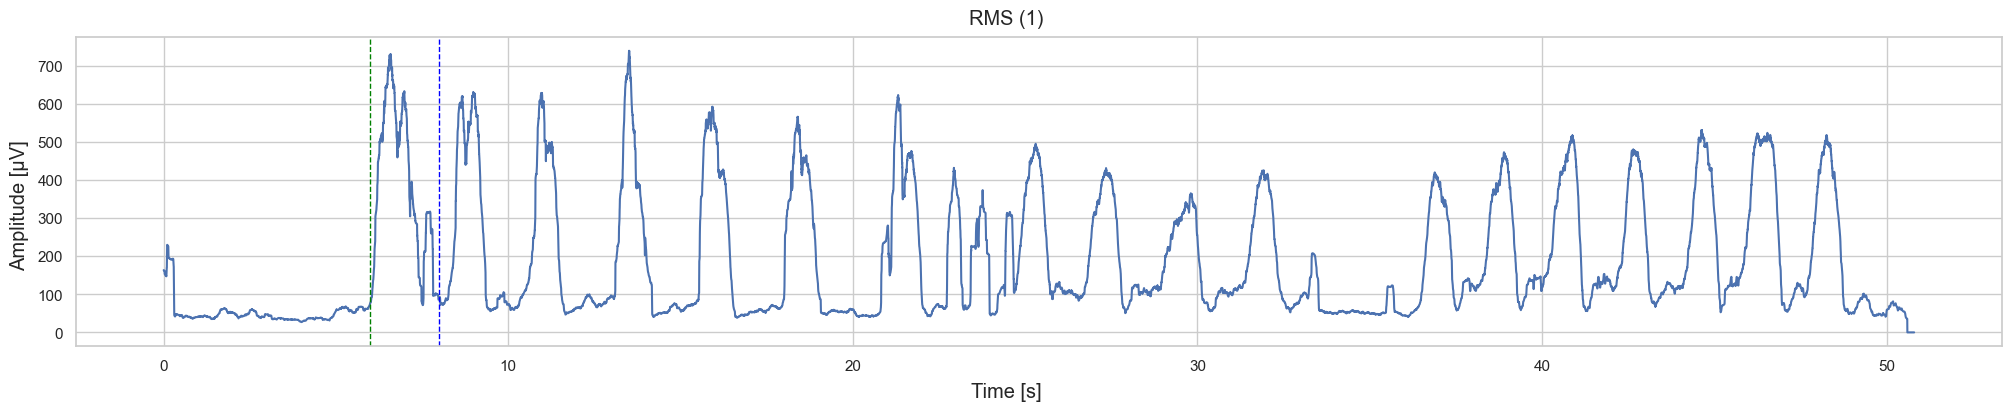

In [8]:
stimulation_starts = [6]
stimulation_ends = [8]
f, ax = plt.subplots(figsize=(20, 4), layout="constrained")
f.suptitle(f"RMS ({SUBJECT_TYPE})")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [\u03bcV]")

t = np.arange(channel_array.shape[1]) / FS
ax.plot(t, emg_rms)
# 在每个刺激的开始和结束点绘制垂直线
for start in stimulation_starts:
    ax.axvline(x=start, color="green", linestyle="--", linewidth=1, label="Start")
for end in stimulation_ends:
    ax.axvline(x=end, color="blue", linestyle="--", linewidth=1, label="End")
plt.show()

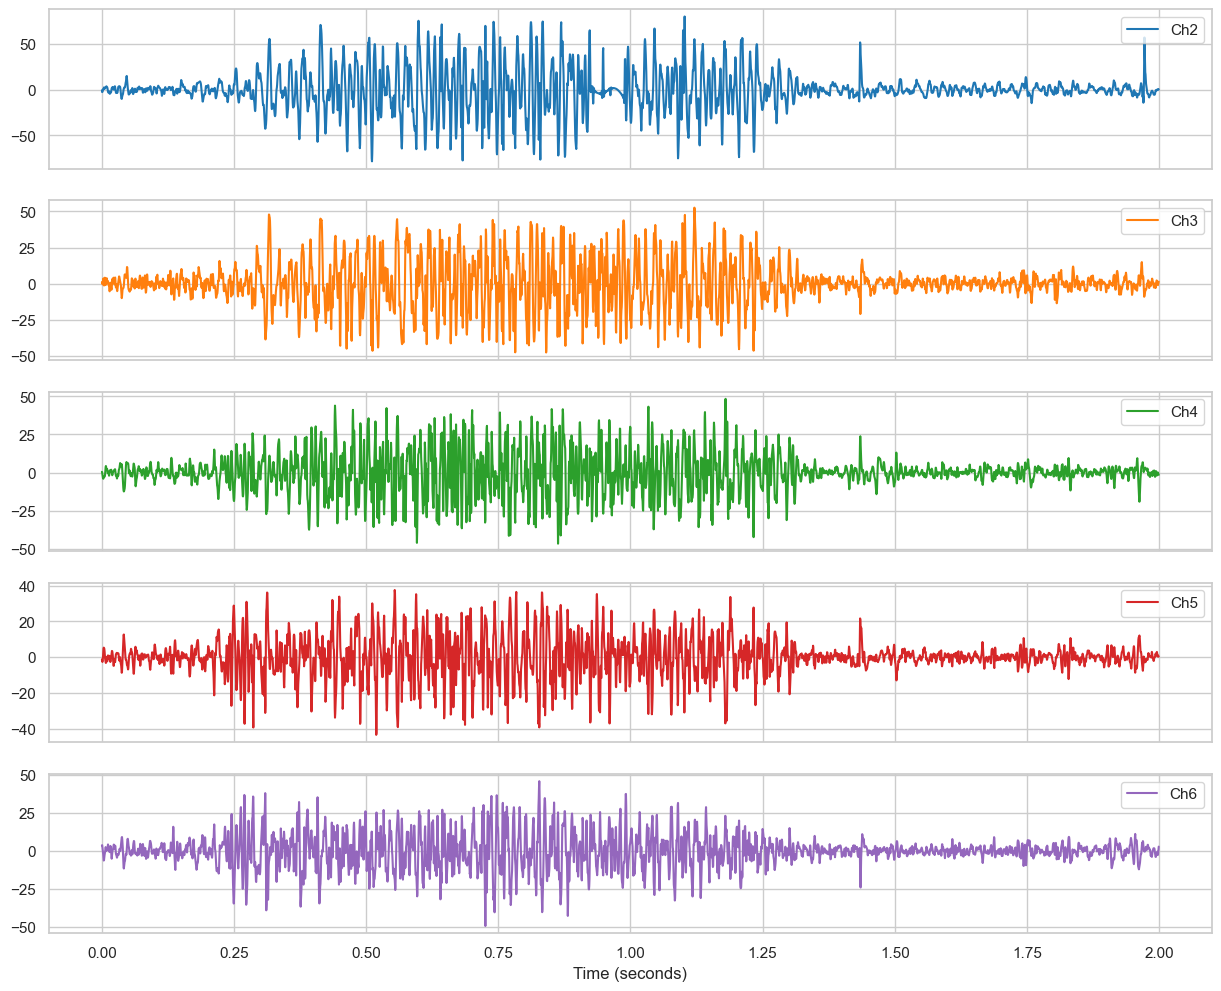

In [9]:
num_selected = 0
channel_array_removed_artifacts = filter_channel_array[
    :,
    int(stimulation_starts[num_selected] * FS) : int(
        stimulation_ends[num_selected] * FS
    ),
]
emg_formal = pd.DataFrame(
    {
        # "Ch1": channel_array_removed_artifacts[0],  # 通道1信号质量较差，选择去除掉
        "Ch2": channel_array_removed_artifacts[1],
        "Ch3": channel_array_removed_artifacts[2],
        "Ch4": channel_array_removed_artifacts[3],
        "Ch5": channel_array_removed_artifacts[4],
        "Ch6": channel_array_removed_artifacts[5],
    }
)
emg_formal.shape
nk.signal_plot(emg_formal, sampling_rate=FS, subplots=True)

## 搜索扩展因子，这个参数比较影响分解结果

In [32]:
def multi_unit_pnr(ics, peak_indices, method="mean"):
    """
    计算多个通道（MU0, MU1, MU2, ...）的总体PNR。

    Parameters
    ----------
    ics: pandas.DataFrame
        每个通道的信号 DataFrame，列为通道名称（如 'MU0', 'MU1', ...），行表示通道信号平方值。
    peak_indices: pandas.DataFrame
        每个通道的二值化峰值索引 DataFrame，形状与ics相同，1表示峰值位置，0表示非峰值位置。
    method: str, optional
        合并多通道PNR的方法，'mean' 表示算术平均，'max' 表示取最大值，'min' 表示取最小值。

    Returns
    -------
    float
        总体PNR值。
    """

    def pnr(s_i, peak_mask, epsilon=1e-10):
        """
        计算Pulse-to-Noise Ratio (PNR)。

        Parameters
        ----------
        s_i : numpy.ndarray
            输入的信号样本。
        peak_mask : numpy.ndarray
            二值化的峰值掩码，1表示峰值，0表示非峰值。
        epsilon : float, optional
            防止除零的小值偏移量，默认值为1e-10。

        Returns
        -------
        float
            计算得到的PNR值。
        """

        # 找到峰值位置（peak_mask 为 1 的位置），并计算平方后的均值
        signal_power = np.mean(s_i[peak_mask == 1] ** 2)

        # 找到噪声位置（peak_mask 为 0 的位置），并计算平方后的均值
        noise_power = np.mean(s_i[peak_mask == 0] ** 2)

        # 防止噪声功率为0，使用epsilon避免log10(0)
        if noise_power == 0:
            return np.inf  # 如果噪声功率为0，返回无穷大的PNR

        # 计算信号和噪声的对数，并返回PNR
        signal_db = 10 * np.log10(signal_power + epsilon)
        noise_db = 10 * np.log10(noise_power + epsilon)

        return signal_db - noise_db

    # 存储每个通道的PNR值
    pnr_values = []

    # 遍历每个通道（列）
    for column in ics.columns:
        s_i = ics[column]  # 取出每个通道的信号
        peak_mask = peak_indices[column]  # 取出通道的二值化峰值索引
        # 计算该通道的 PNR
        pnr_value = pnr(s_i.copy(), peak_mask.copy())  # 使用副本，避免修改原数据
        pnr_values.append(pnr_value)

    pnr_values = np.array(pnr_values)

    # 根据指定的方法合并PNR值
    if method == "mean":
        return pnr_values.mean()
    elif method == "max":
        return pnr_values.max()
    elif method == "min":
        return pnr_values.min()
    else:
        raise ValueError("method参数只能为 'mean', 'max', 或 'min'")


from datetime import datetime

f_ext_values = range(1, 70)  # 从50到70的f_ext

max_spike_count = 0  # 用于记录最大spikes_t.keys()的个数
best_f_ext = 6  # 用于记录对应最大spikes_t.keys()个数的f_ext

# 获取当前的时间并格式化为文件名
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"{current_time}.txt"
PNR_best = 0
# 打开文件用于写入
with open(filename, "w") as file:
    # 写入表头
    file.write("f_ext, spike_count, PNR\n")

    # 循环遍历f_ext
    for f_ext in f_ext_values:
        # 初始化 ConvBSS
        conv_bss = emgkit.decomposition.ConvBSS(
            fs=FS,
            f_ext=f_ext,
            # sil_th=0.7,
            seed=SEED,
            dr_th=3,
            device=DEVICE,
        )

        # 执行分解
        ics, spikes_t = conv_bss.decompose_training(emg_formal)
        ext_sig_len_s = ics.shape[0] / FS
        PNR = multi_unit_pnr(
            ics, emgkit.utils.sparse_to_dense(spikes_t, ext_sig_len_s, FS)
        )
        # 获取当前 spikes_t.keys() 的个数
        spike_count = len(spikes_t.keys())

        # 记录当前的 f_ext 和 spike_count
        file.write(f"{f_ext}, {spike_count}, {PNR}\n")

        # 判断是否为当前最大的个数
        # if spike_count > max_spike_count:
        if PNR > PNR_best:
            max_spike_count = spike_count
            best_f_ext = f_ext

    # 记录最佳的 f_ext 和最大 spikes_t.keys() 的个数
    file.write("\n")
    file.write(f"最大 spikes_t.keys() 的个数: {PNR_best}\n")
    file.write(f"最佳的 f_ext: {best_f_ext}\n")

# 输出结果
print(f"数据已保存到文件: {filename}")
print(f"最佳的 f_ext: {best_f_ext}")
print(f"最大 spikes_t.keys() 的个数: {max_spike_count}")

INFO:root:Number of channels before extension: 5
INFO:root:Number of channels after extension: 5
INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 20 iterations, the distance is: 8.388e-05.
INFO:root:CoV-ISI decreased from 97.46% to 96.80% after 1 steps.
INFO:root:CoV-ISI decreased from 96.80% to 96.73% after 2 steps.
INFO:root:CoV-ISI increased from 96.73% to 96.79% after 3 steps.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 21 iterations, the distance is: 6.890e-05.
INFO:root:CoV-ISI increased from 48.80% to 48.80% after 1 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 31 iterations, the distance is: 8.793e-05.
INFO:root:CoV-ISI increased from 51.96% to 66.90% after 1 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 4 iterations, the distance is: 9.308e-05.
INFO:root:CoV-ISI decreased from 26.65% to 24.08% after 1 steps.
INFO:root:CoV-ISI increased from 24.08% to 55.31% after 2 steps.
INFO:root:----- IC 5 -----
INFO:r

数据已保存到文件: 2024-10-19_19-00-27.txt
最佳的 f_ext: 69
最大 spikes_t.keys() 的个数: 2


In [34]:
conv_bss = emgkit.decomposition.ConvBSS(
    fs=FS,
    f_ext=62,
    seed=SEED,
    # sil_th=0.7,
    dr_th=3,
    device=DEVICE,
)

ics, spikes_t = conv_bss.decompose_training(emg_formal)
ext_sig_len_s = ics.shape[0] / FS

INFO:root:Number of channels before extension: 5
INFO:root:Number of channels after extension: 310
INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 35 iterations, the distance is: 7.357e-05.
INFO:root:CoV-ISI increased from 129.18% to 129.18% after 1 steps.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 38 iterations, the distance is: 8.615e-05.
INFO:root:CoV-ISI increased from 24.12% to 24.12% after 1 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 35 iterations, the distance is: 6.108e-05.
INFO:root:CoV-ISI increased from 129.19% to 129.19% after 1 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 59 iterations, the distance is: 8.313e-05.
INFO:root:CoV-ISI increased from 128.93% to 128.93% after 1 steps.
INFO:root:----- IC 5 -----
INFO:root:FastICA converged after 37 iterations, the distance is: 8.234e-05.
INFO:root:CoV-ISI increased from 42.70% to 42.70% after 1 steps.
INFO:root:----- IC 6 -----
INFO:root:FastICA conve

In [35]:
PNR = multi_unit_pnr(ics, emgkit.utils.sparse_to_dense(spikes_t, ext_sig_len_s, FS))
PNR

22.208780828747663

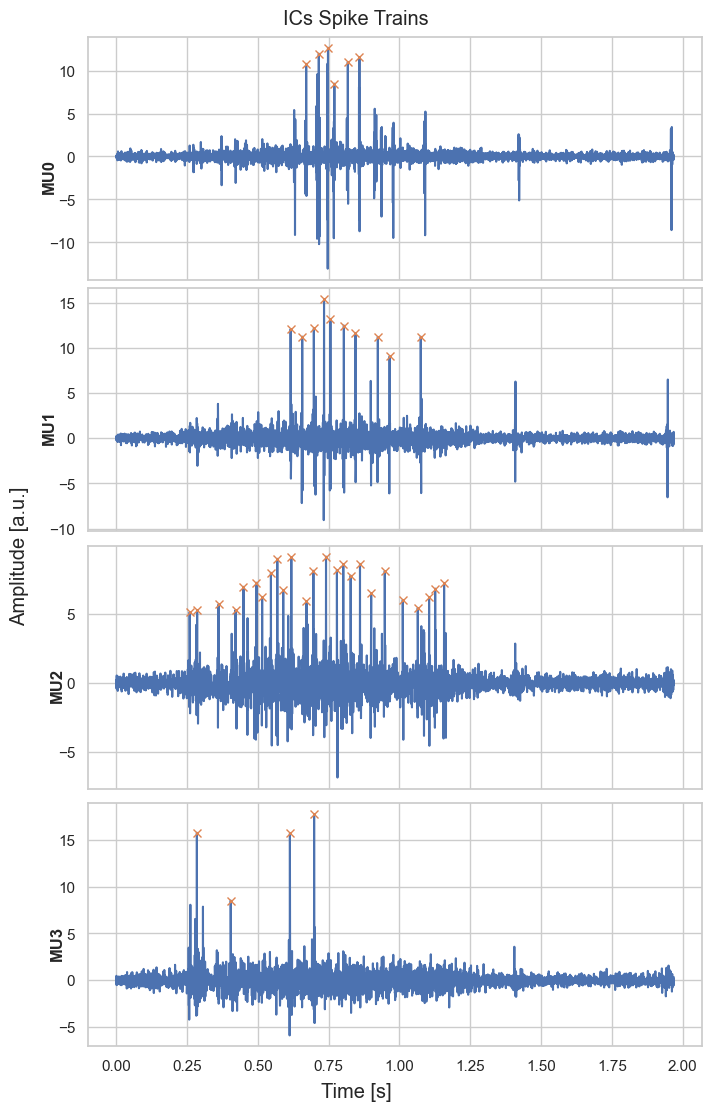

In [36]:
emgkit.plotting.plot_ic_spikes(ics, spikes_t, fig_size=(7, 11))

Display the raster plot.

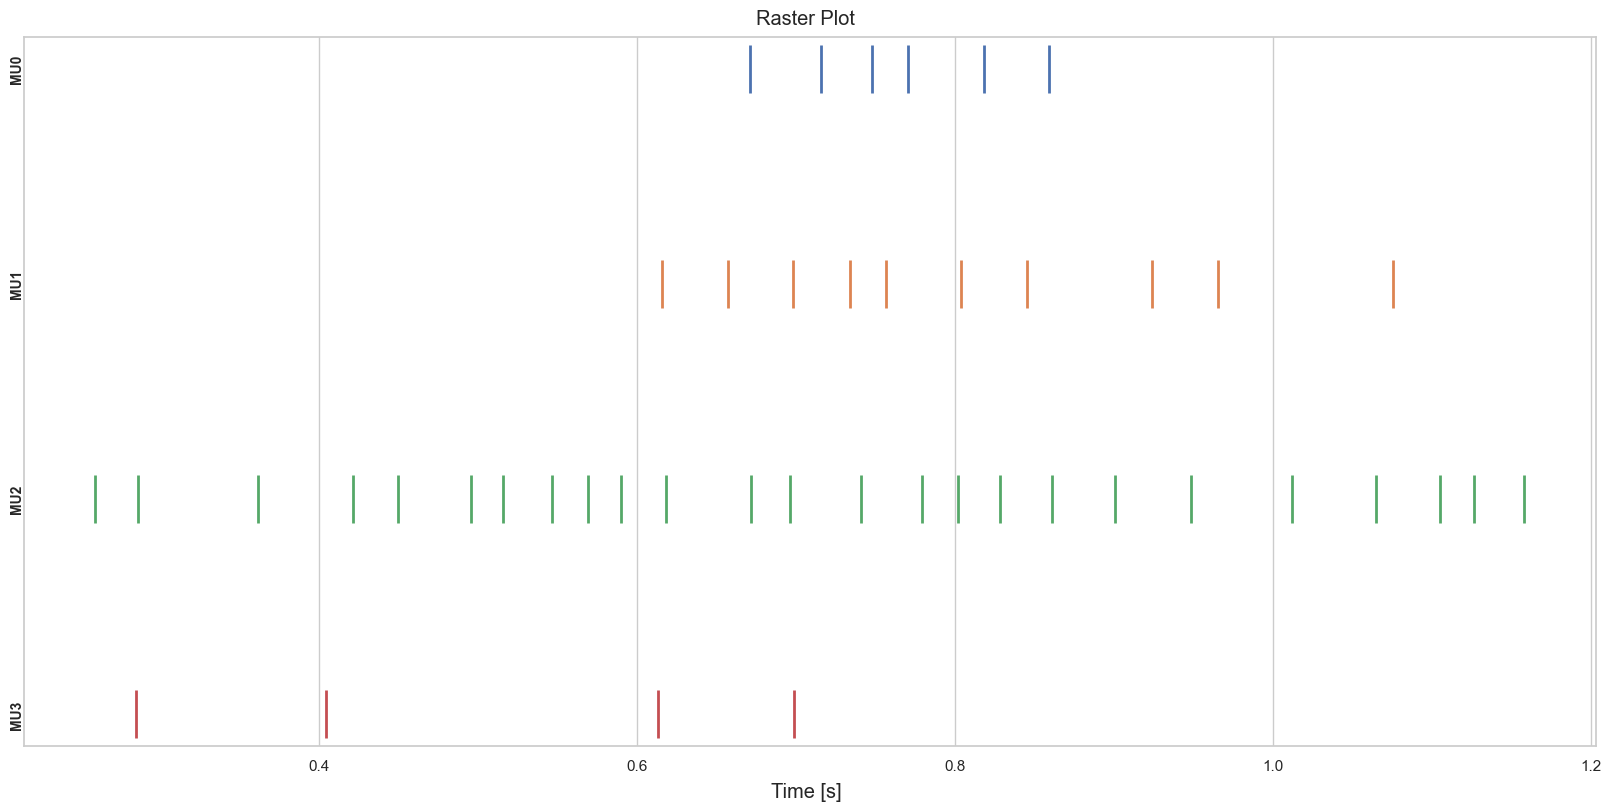

In [37]:
emgkit.plotting.raster_plot(spikes_t, fig_size=(16, 8))

Display the discharge rate.

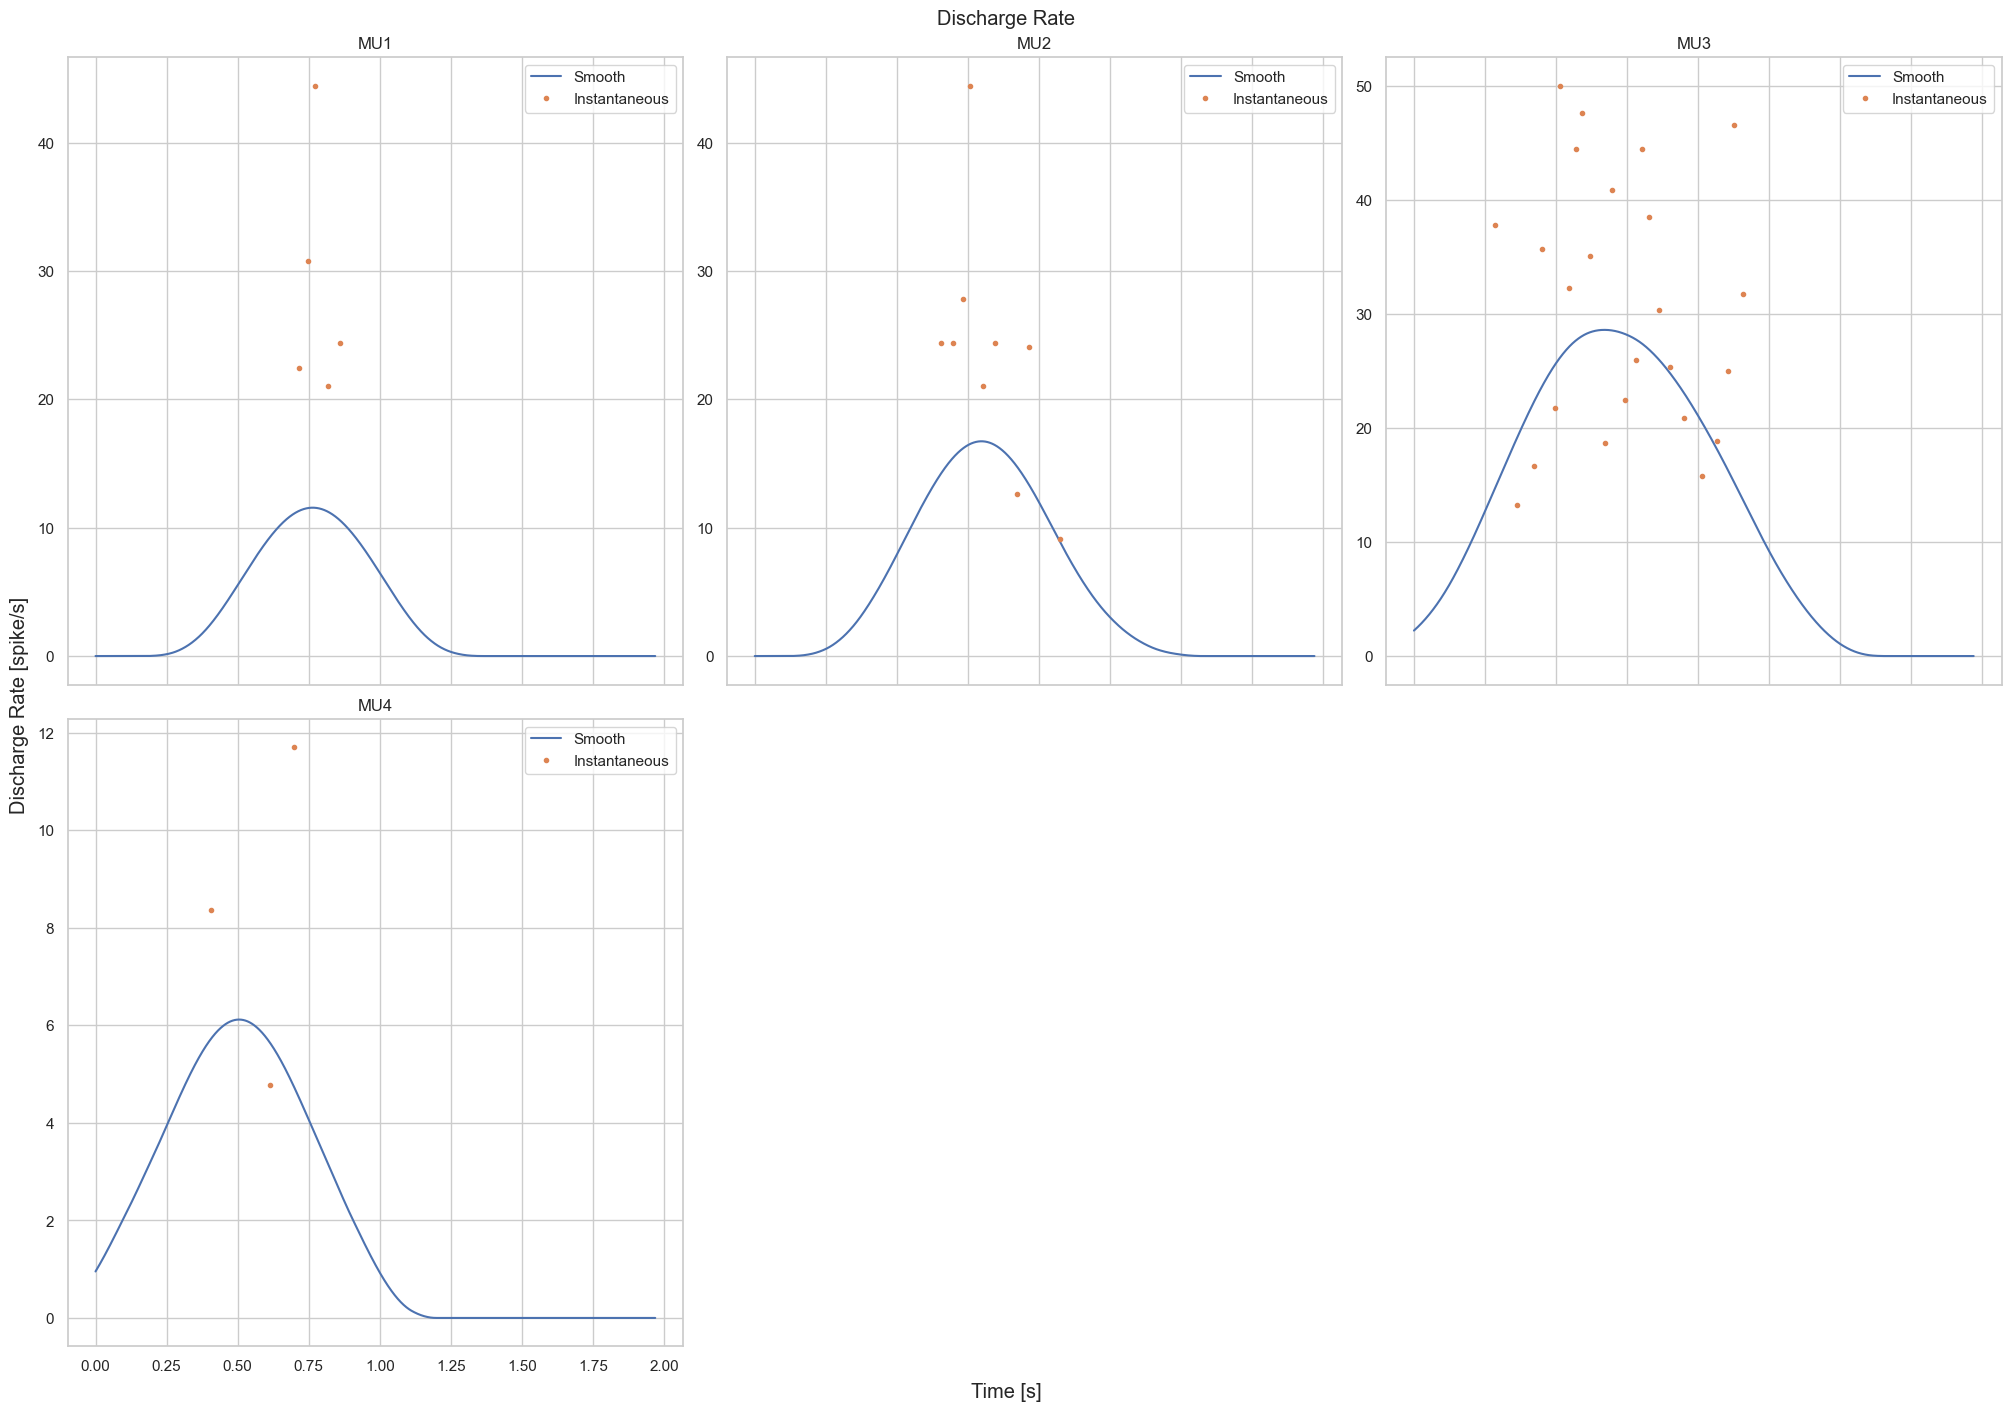

In [38]:
emgkit.plotting.plot_discharges(spikes_t, ext_sig_len_s, FS, fig_size=(20, 14))

Compute the waveforms and plot them.

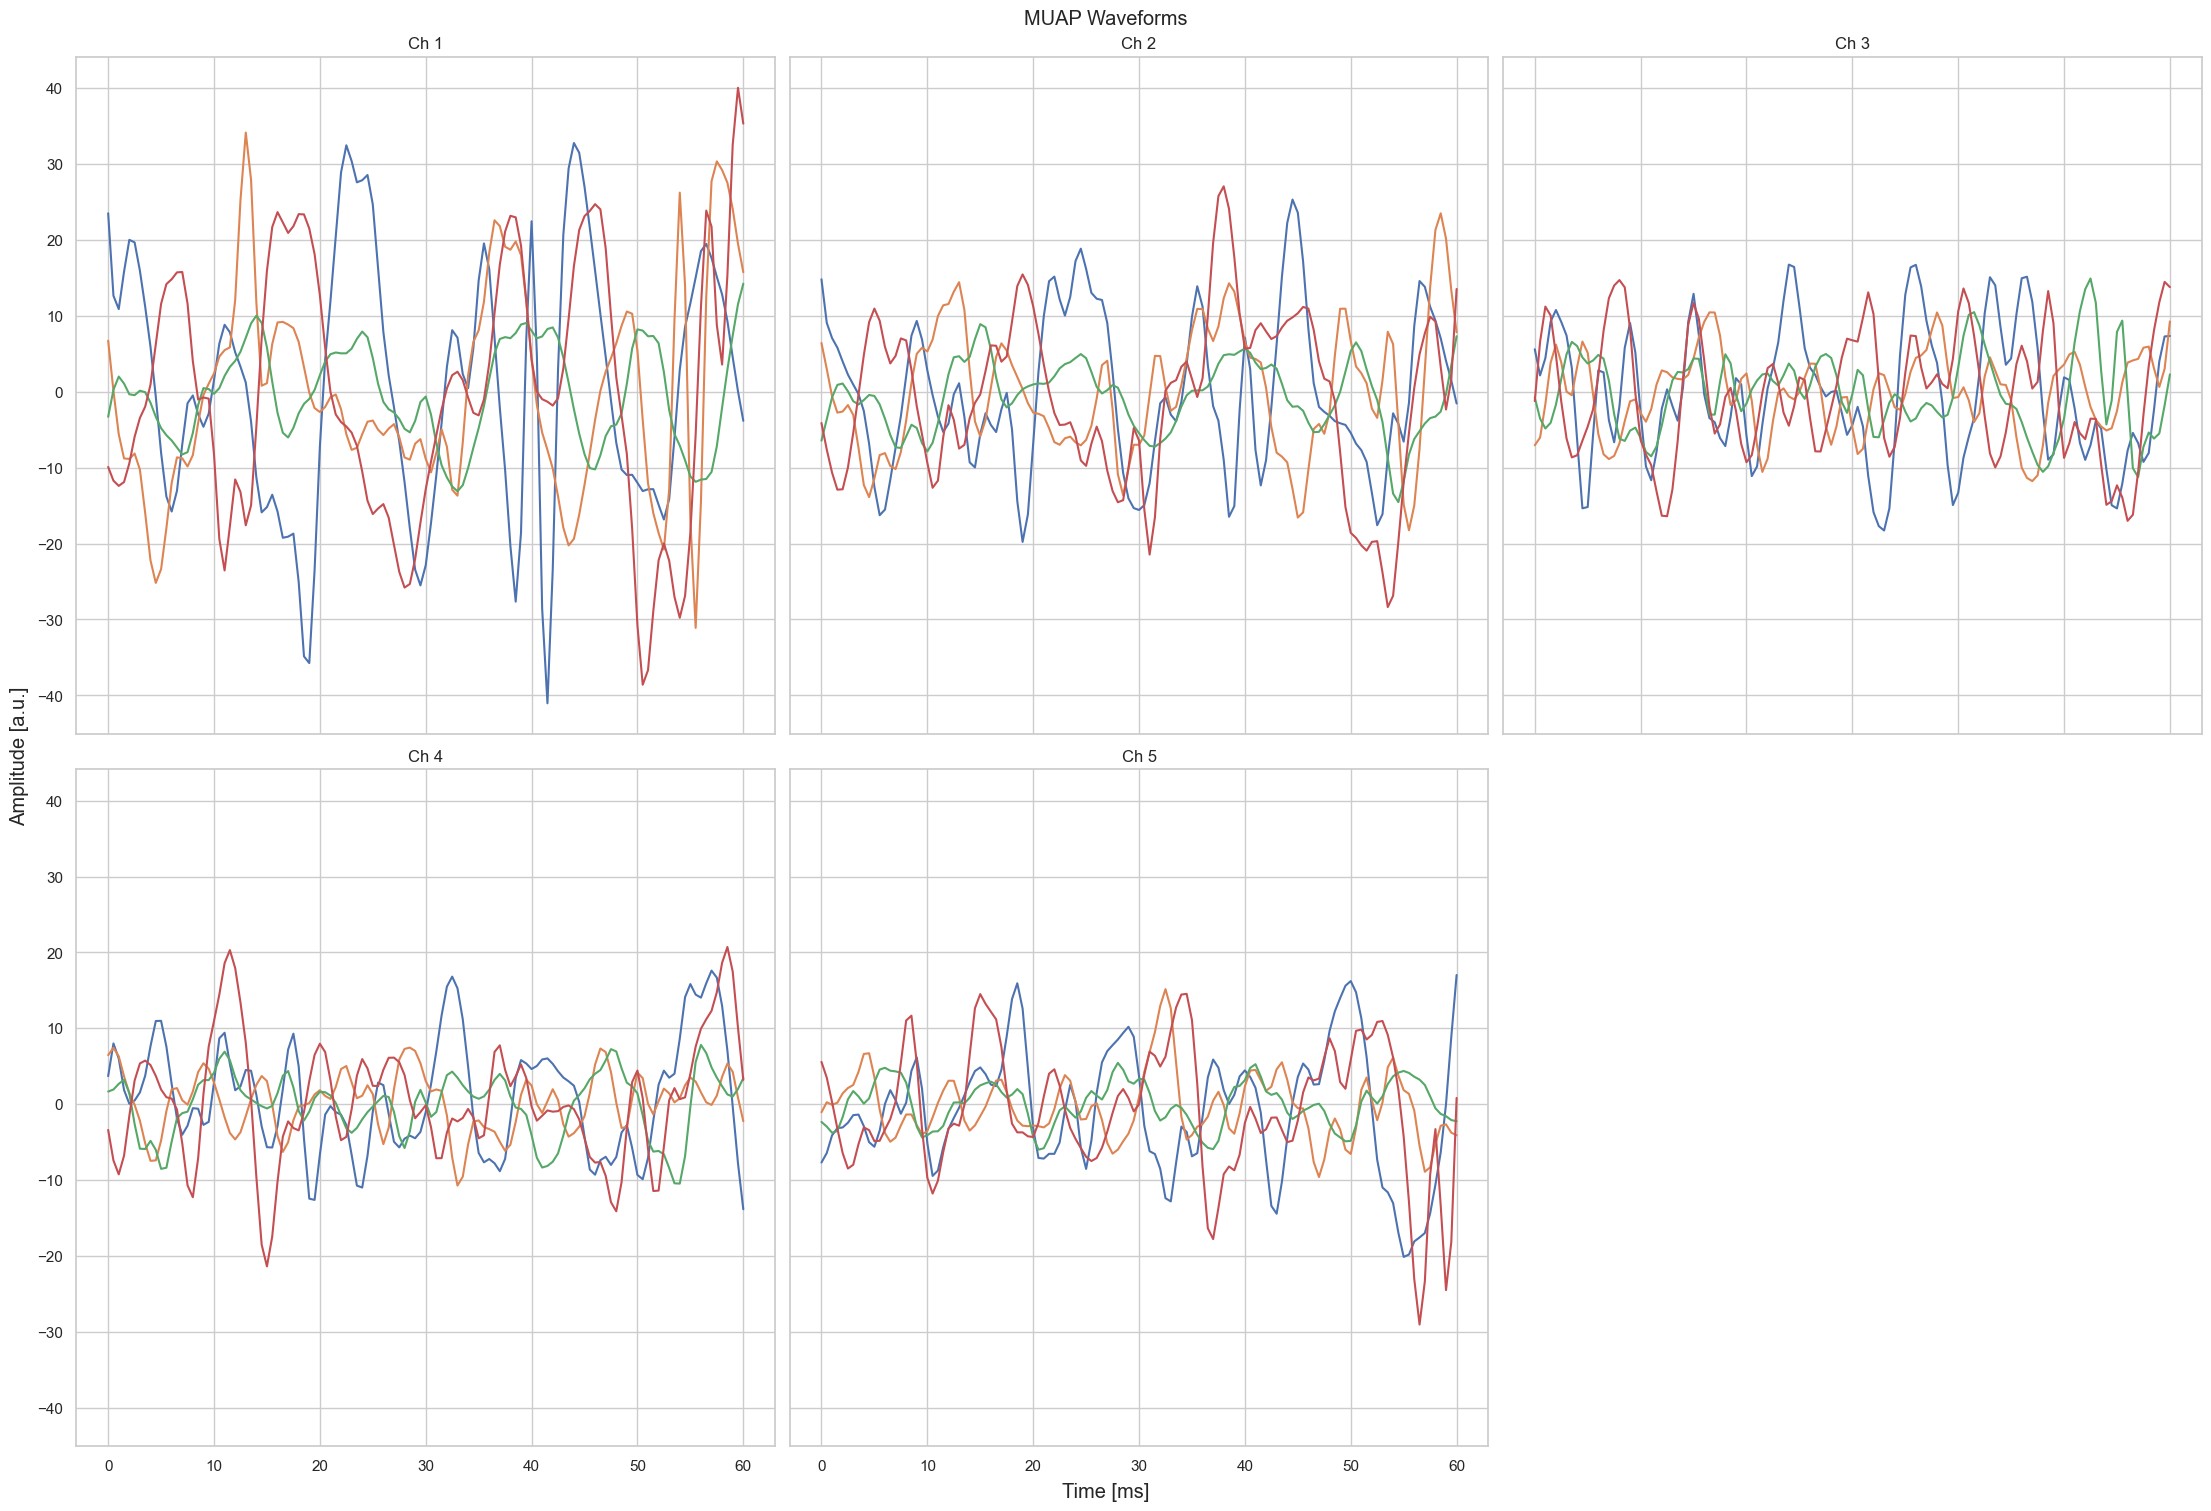

In [39]:
wfs = emgkit.utils.compute_waveforms(emg_formal, spikes_t, wf_radius_ms=30.0, fs=FS)

emgkit.plotting.plot_waveforms(wfs, fs=FS, n_cols=3, fig_size=(22, 15))